# Dönem Projem

  Using cached scapy-2.7.0-py3-none-any.whl.metadata (5.8 kB)
Using cached scapy-2.7.0-py3-none-any.whl (2.6 MB)
Okunuyor: /content/data/BenignTraffic.pcap...
Okunuyor: /content/data/DDoS-SYN_Flood.pcap...
Okunuyor: /content/data/Mirai-udpplain.pcap...
Okunuyor: /content/data/Recon-PortScan.pcap...

CNN Eğitiliyor...
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.6458 - loss: 0.8735 - val_accuracy: 0.7644 - val_loss: 0.5694
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.8032 - loss: 0.5064 - val_accuracy: 0.8472 - val_loss: 0.3938
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.8632 - loss: 0.3514 - val_accuracy: 0.8631 - val_loss: 0.3498
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.8983 - loss: 0.2699 - val_accuracy: 0.8922 - val_loss: 0.2951
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - accuracy: 0.9216 - loss: 0.2168 - val_accuracy: 0.8856 - val_loss: 0.3042
Epoch 6/10
400/400 ━━━━━━━━━━━━

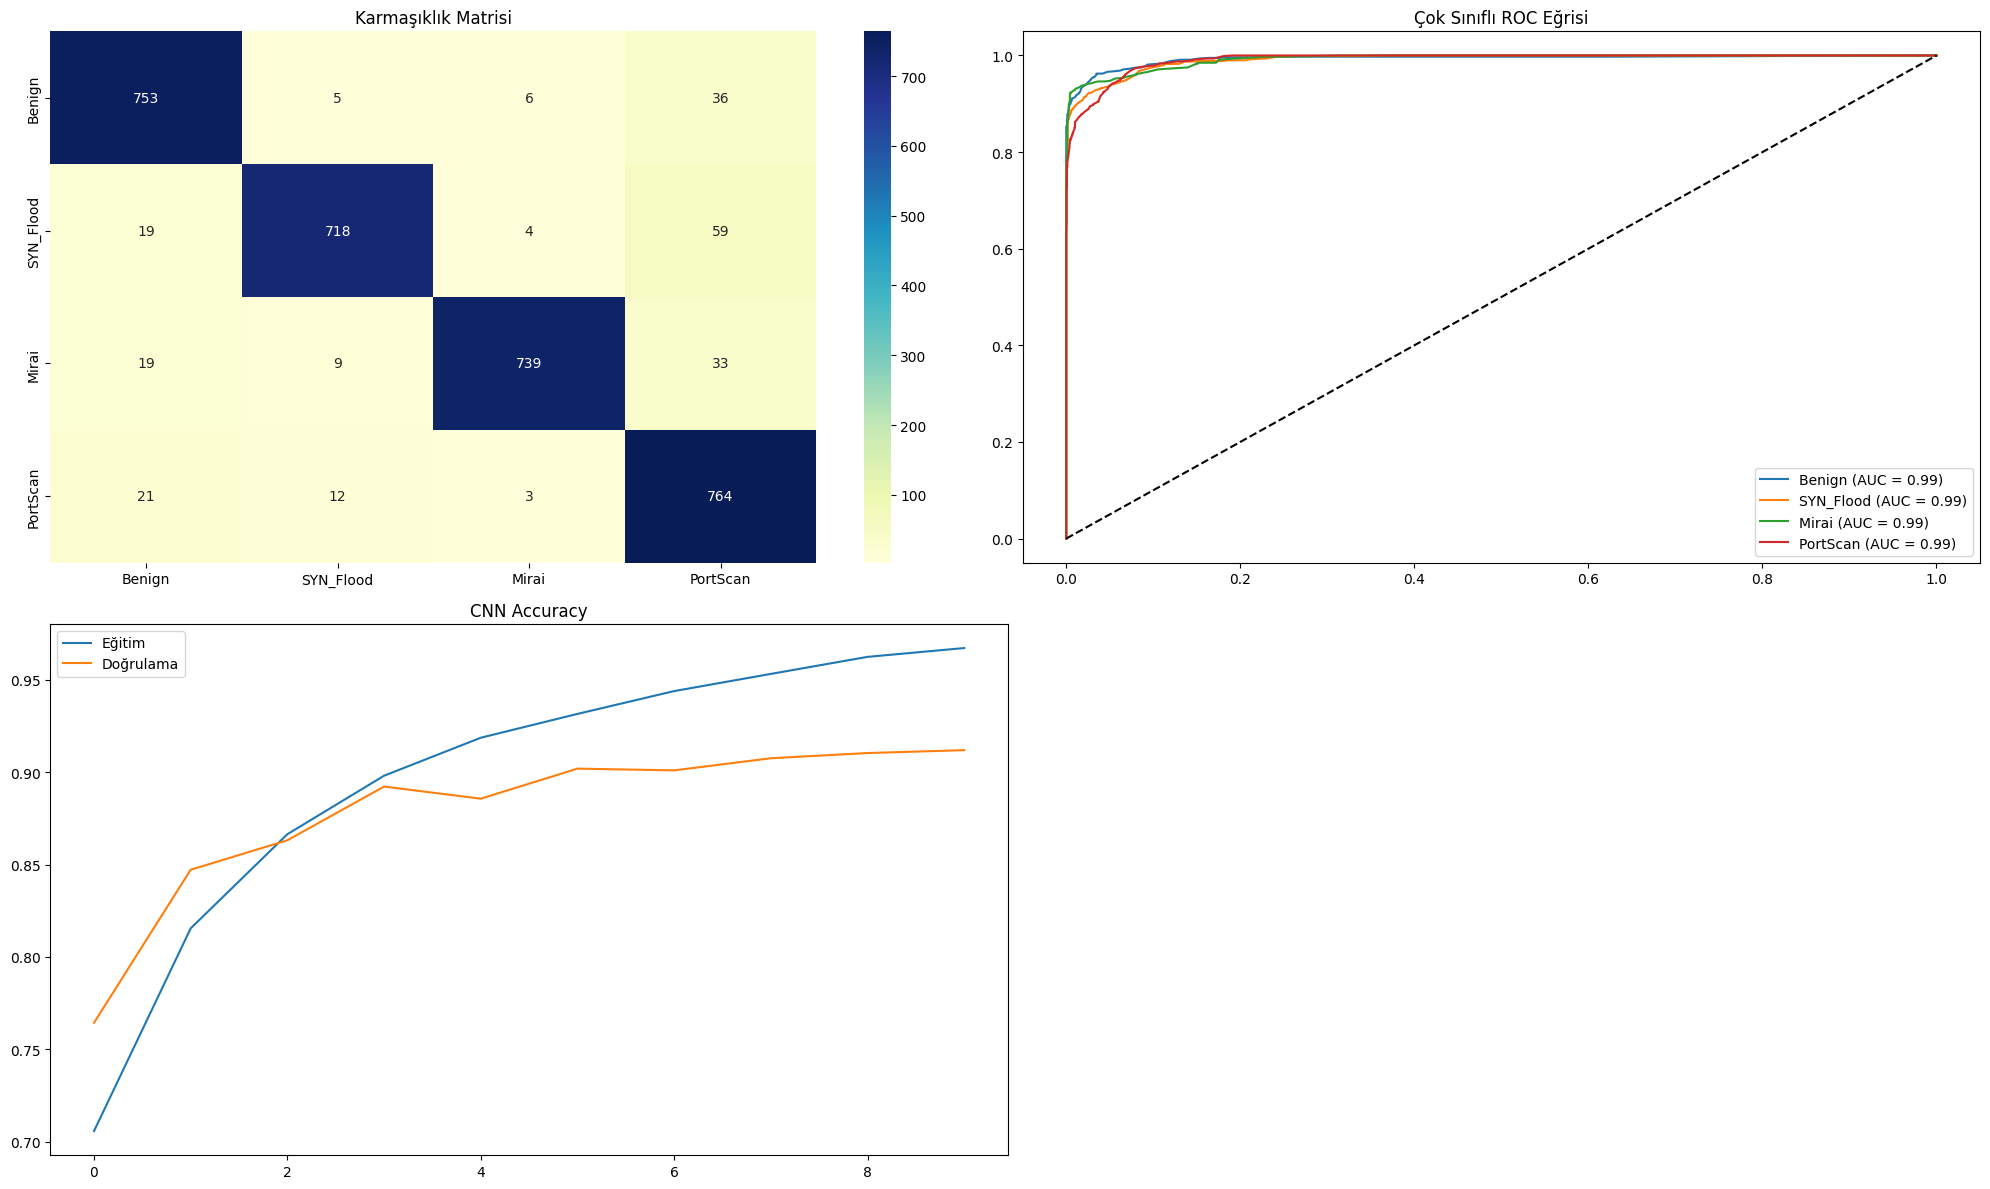


--- SONUÇLAR ---
En İyi Parametreler: {'max_depth': None, 'n_estimators': 100}
Doğruluk: 0.9294
              precision    recall  f1-score   support

      Benign       0.93      0.94      0.93       800
   SYN_Flood       0.97      0.90      0.93       800
       Mirai       0.98      0.92      0.95       800
    PortScan       0.86      0.95      0.90       800

    accuracy                           0.93      3200
   macro avg       0.93      0.93      0.93      3200
weighted avg       0.93      0.93      0.93      3200



In [2]:
!pip install scapy

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import PcapReader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


DATA_PATH = '/content/data/'

FILE_CONFIG = {
    'BenignTraffic.pcap': 0,
    'DDoS-SYN_Flood.pcap': 1,
    'Mirai-udpplain.pcap': 2,
    'Recon-PortScan.pcap': 3
}

class_names = ['Benign', 'SYN_Flood', 'Mirai', 'PortScan']
MAX_PACKETS = 4000
IMG_SIZE = 28

def process_pcap(filename, label):
    data, labels = [], []
    count = 0
    full_path = os.path.join(DATA_PATH, filename)

    print(f"Okunuyor: {full_path}...")

    if not os.path.exists(full_path):
        print(f"HATA: Dosya bulunamadı -> {full_path}")
        return np.array([]), np.array([])

    try:
        with PcapReader(full_path) as reader:
            for packet in reader:
                if count >= MAX_PACKETS: break
                raw = bytes(packet)
                raw = raw[:IMG_SIZE**2].ljust(IMG_SIZE**2, b'\x00')
                img = np.frombuffer(raw, dtype=np.uint8).reshape(IMG_SIZE, IMG_SIZE)
                data.append(img)
                labels.append(label)
                count += 1
    except Exception as e:
        print(f"Hata ({filename}): {e}")

    return np.array(data), np.array(labels)

X_list, y_list = [], []
for file_name, label_id in FILE_CONFIG.items():
    x_t, y_t = process_pcap(file_name, label_id)
    if len(x_t) > 0:
        X_list.append(x_t)
        y_list.append(y_t)

if not X_list:
    print("HATA: Veri yüklenemedi!")
else:
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    #CNN FEATURE EXTRACTOR

    y_train_cat = to_categorical(y_train, num_classes=4)
    y_test_cat = to_categorical(y_test, num_classes=4)

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    flatten_layer = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(flatten_layer)
    outputs = layers.Dense(4, activation='softmax')(x)

    cnn = models.Model(inputs=inputs, outputs=outputs)
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print("\nCNN Eğitiliyor...")
    history = cnn.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1)

    feature_extractor = models.Model(inputs=cnn.input, outputs=flatten_layer)
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    print("\nRandom Forest Optimizasyonu...")
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 20]
    }

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(rf, param_grid, cv=2, verbose=1)
    grid.fit(X_train_features, y_train)
    best_rf = grid.best_estimator_
    y_pred = best_rf.predict(X_test_features)
    y_score = best_rf.predict_proba(X_test_features)


    plt.figure(figsize=(20, 12))

    plt.subplot(2, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.title('Karmaşıklık Matrisi')

    plt.subplot(2, 2, 2)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Çok Sınıflı ROC Eğrisi')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history.history['accuracy'], label='Eğitim')
    plt.plot(history.history['val_accuracy'], label='Doğrulama')
    plt.title('CNN Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n--- SONUÇLAR ---")
    print(f"En İyi Parametreler: {grid.best_params_}")
    print(f"Doğruluk: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))